# Chebyshev Testing

Code to test approximating the transfer opperator with Chebyshev approximations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from chebyshev_hofbauer_resonances.linear_tent_map.operator_approx import (
    cheb_op_ap,
    domain_restricted_chebyt,
    restircted_chebfit,
)

In [2]:
# This is the tent map and the corespoding transfer operator.
alpha = 0.6


def tent_map(x):
    return alpha * np.minimum(x, 1 - x)


def L(phi):
    return (
        lambda x: (1 / alpha) * (phi(x / alpha) + phi(1 - x / alpha)) * (x <= alpha / 2)
    )


# left branch
def tent_map(x):
    return np.where((x >= 0) & (x <= 1 / 2), alpha * x, np.nan)


def L(phi):
    return lambda x: np.where(
        (x >= 0) & (x <= alpha / 2), (1 / alpha) * (phi(x / alpha)), np.nan
    )

In [3]:
# Some sample function to test the code on.
def f(x):
    return 3 * x**2


# Samples from the test function
samples = (np.random.uniform(0, 1, 100_000)) ** (1 / 3)

# Transfering the samples using the tent map.
transformed_samples = tent_map(samples)

In [4]:
degree = 50
K = degree
N = degree

initial_domain = (0, 1)
x = np.linspace(initial_domain[0], initial_domain[1], 100)

final_domain = (0, alpha / 2)
x_final = np.linspace(final_domain[0], final_domain[1], 100)

# Fitting cheb to the sample function
cheb_coeffs = restircted_chebfit(f, domain=initial_domain, degree=degree)

# The approximation of the transfer operator
L_hat = cheb_op_ap(L, K, N, initial_domain=initial_domain, final_domain=final_domain)

In [5]:
# The new coefficients after applying the transfer opperator
transformed_coeffs = L_hat.T @ cheb_coeffs

# The cheb approximation of the original test function
original_values = cheb_coeffs @ np.array(
    [domain_restricted_chebyt(n, initial_domain)(x) for n in range(N)]
)

# The transformed cheb approximation of the original test function.
# I.e. the approximation of the test function after applying the transfer operator.
transformed_values = transformed_coeffs @ np.array(
    [domain_restricted_chebyt(n, final_domain)(x_final) for n in range(N)]
)

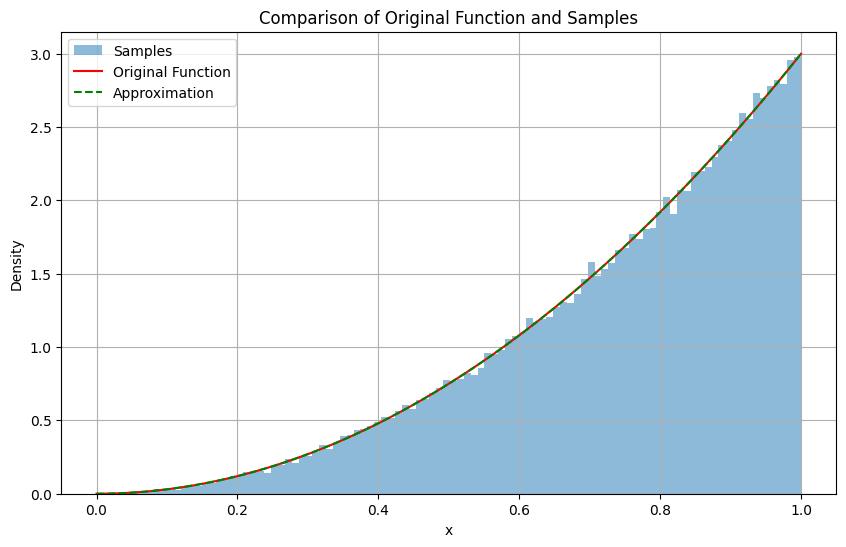

In [6]:
# Plot showing how the original function and the samples are similar

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(samples, bins=100, density=True, alpha=0.5, label="Samples")
ax.plot(x, f(x), c="red", label="Original Function")
ax.plot(x, original_values, c="green", label="Approximation", ls="--")
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Comparison of Original Function and Samples")
ax.legend()
ax.grid(True)
plt.show()

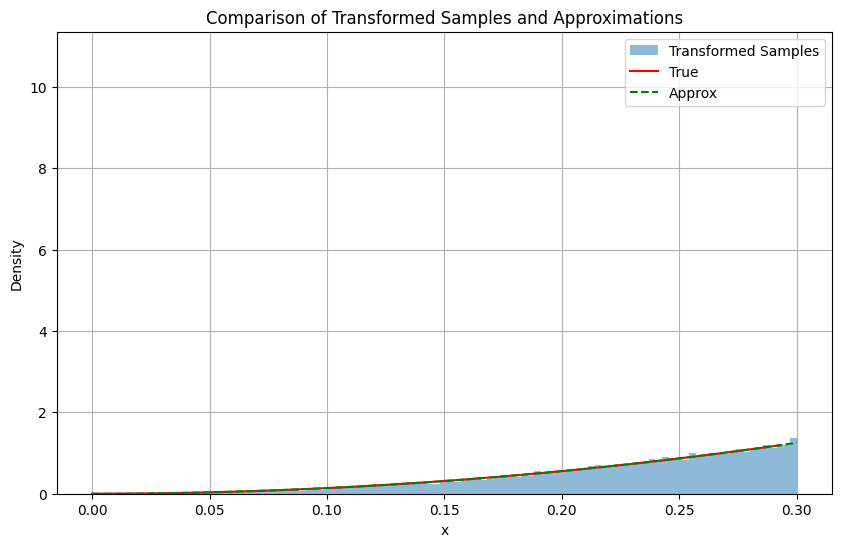

In [7]:
# A plot of the transferred samples, the transfer operator applied to the original function, and the approximation using the cheby method
fig, ax = plt.subplots(figsize=(10, 6))
counts, bins, patches = ax.hist(
    transformed_samples, density=True, bins=100, alpha=0.5, label="Transformed Samples"
)
scaling_factor = len(transformed_samples) / (
    len(transformed_samples) - np.sum(np.isnan(transformed_samples))
)
for patch in patches:
    patch.set_height(patch.get_height() / scaling_factor)

ax.plot(x, L(f)(x), label="True", color="red")
ax.plot(x_final, transformed_values, label="Approx", color="green", ls="--")
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Comparison of Transformed Samples and Approximations")
ax.legend()
ax.grid(True)
plt.show()